# Calibration of multiple parameters for ASPICS model, using ABC method

This jupyter notebook is based on the previous efforts from DyME and Prof Nick Malleson (University of Leeds)

- [RAMP-UA Initiative](https://github.com/Urban-Analytics/RAMP-UA/blob/d5973dff007645f1700cded93aaf72298ef84c61/experiments/calibration/abc-1.ipynb)

- [Calibrating Agent-Based Models Using Uncertainty Quantification Methods](https://github.com/Urban-Analytics/uncertainty/blob/master/hm_abc_simple_example.ipyn)

As SPC (Synthetic Population Catalyst) is a tool that helps urban modelling researchers to get synthetic population datasets at national level (currently limitated to England). This tool opens up new challenges/possibilities where external models (multi-level) like Agent-based models -ABM now can be tested in multi regions. However in models with location parameters striclty dependend on the population interactions, internal validation and calibrations process are seen as a relevant and requiered to properly tune this national behaivor. 

### ToDO to make progress in this experiment
- [X] Read the Synt Pop file - Translate to snaphot then ASPICS can read the new dataset.
- [] Read and plot the attributes we need, we could plot
- [] Read the baseline use as priors - Areas to test Leeds ( ideally West Yorkshire), Liverpool, Devon, Manchester (Grand Manchester)

## Background Concepts

- Uncertanity of ABM
- Methods for Calibration
- ABC

In [1]:
import math
import pandas as pd
import sys, os
import matplotlib.pyplot as plt
import numpy as np
import random
from yaml import load, SafeLoader
sys.path.append('../')
from run_aspics import OpenCLRunner
from aspics.loader import setup_sim, create_params
from headless import run_headless
import synthpop_pb2
import convert_snapshot

The following function is based on [SPC scripts](https://github.com/alan-turing-institute/uatk-spc/blob/main/python/protobuf_to_csv.py) the idea is to read the .pb file created with the tool. However, we need to make a translation from the proto file to snapshot which will integarte the data in the way ASPICS need it.

## Read the baseline data. Defined as prior to calibrate the model to a given area
Real observations (number of cases, deaths or hospital admission in the given area)
They need to be made cumulative as this is how they will be compared to the model.

#### Rutland area as test run due it size
The data for no of cases and the gam_cases data were created using [Ramp-UA - Observation Data](https://github.com/Urban-Analytics/RAMP-UA/tree/master/experiments/calibration/observation_data)

In [2]:
# New per day:
gam_cases = pd.read_csv(os.path.join("baseline_data", "gam_manchester_cases.csv"), header=0, names=["Day", "Cases"], )
# Cumulative
OBSERVATIONS = pd.DataFrame( {"Day": gam_cases['Day'], "Cases": gam_cases.cumsum()['Cases']} )
assert OBSERVATIONS.tail(1)['Cases'].values[0] == sum(gam_cases['Cases'])
print(f"Total cases: {sum(gam_cases['Cases'])}")

Total cases: 34166


## Run ASPIC using the default parameters

The following cells provide a set of plots to define how the model run with the default parameters ( manually calibrated for Devon area). In this example we use Rutland.

Before everything, we need to translate the .pb (protobufer) file to the snapshot required by ASPCIS [Usage guide](docs/usage_guide.md). You need to do this one time. Once you created your synthetic population file, then run 'run ../convert_snapshot.py -i SPC_data/{YOUR_NEW_AREA}.pb -o ../data/snapshots/{YOUR_NEW_AREA}/cache.npz'


Great now we have the cache.npz file in `data/snapshots`


In [6]:
os.getcwd()

'/Users/fbenitez/PycharmProjects/uatk-aspics'

In [4]:
os.chdir("../") #Now we need to update the main directory then we can use aspics as the way was created.

In [7]:
PARAMETERS_FILE = 'config/Manchester.yml' # Reading the parameters file
with open(PARAMETERS_FILE, "r") as f:
    parameters = load(f, Loader=SafeLoader)

simulator, snapshot, study_area, iterations = setup_sim(parameters)  #Initial configuration, based on the parameters to run the model
summary, final_state = run_headless(simulator, snapshot, iterations, quiet=False, store_detailed_counts=True) #run the model in a headless mode

Running a manually added parameters simulation based on {'microsim': {'study-area': 'Manchester', 'iterations': 80, 'use-lockdown': False, 'start-date': 10, 'output': True, 'output-every-iteration': False, 'opencl-model': True, 'repetitions': 1}, 'microsim_calibration': {'hazard_individual_multipliers': {'presymptomatic': 1, 'asymptomatic': 0.75, 'symptomatic': 1.0}, 'hazard_location_multipliers': {'Retail': 1.0, 'PrimarySchool': 1.0, 'SecondarySchool': 1.0, 'Home': 1.0, 'Work': 1.0}, 'risk_multiplier': 1.0}, 'disease': {'current_risk_beta': 0.003, 'risk_cap': 5, 'seed_days': 10, 'exposed_dist': 'weibull', 'exposed_mean': 2.56, 'exposed_sd': 0.72, 'presymp_dist': 'weibull', 'presymp_mean': 2.3, 'presymp_sd': 0.35, 'infection_dist': 'lognormal', 'infection_mean': 7, 'infection_sd': 1.3, 'output_switch': True, 'rank_assign': False, 'local_outbreak_timestep': 7, 'local_outbreak': False, 'msoa_infect': 'E02004161', 'number_people_local': 100, 'local_prob_increase': 1.0, 'overweight_sympt_m

/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "
Running simulation: 100%|██████████| 80/80 [00:03<00:00, 20.83it/s]


Day 0
	Susceptible: 177129
	Exposed: 46
	Presymptomatic: 0
	Asymptomatic: 163
	Symptomatic: 88
	Recovered: 34
	Dead: 0

Day 1
	Susceptible: 177091
	Exposed: 69
	Presymptomatic: 4
	Asymptomatic: 142
	Symptomatic: 78
	Recovered: 76
	Dead: 0

Day 2
	Susceptible: 177051
	Exposed: 83
	Presymptomatic: 11
	Asymptomatic: 127
	Symptomatic: 64
	Recovered: 124
	Dead: 0

Day 3
	Susceptible: 177005
	Exposed: 86
	Presymptomatic: 20
	Asymptomatic: 132
	Symptomatic: 56
	Recovered: 161
	Dead: 0

Day 4
	Susceptible: 176935
	Exposed: 114
	Presymptomatic: 29
	Asymptomatic: 140
	Symptomatic: 50
	Recovered: 192
	Dead: 0

Day 5
	Susceptible: 176853
	Exposed: 148
	Presymptomatic: 34
	Asymptomatic: 144
	Symptomatic: 53
	Recovered: 228
	Dead: 0

Day 6
	Susceptible: 176763
	Exposed: 176
	Presymptomatic: 44
	Asymptomatic: 162
	Symptomatic: 67
	Recovered: 248
	Dead: 0

Day 7
	Susceptible: 176630
	Exposed: 237
	Presymptomatic: 57
	Asymptomatic: 189
	Symptomatic: 80
	Recovered: 267
	Dead: 0

Day 8
	Susceptible: 176

## Run ASPIC using the manually defined parameters


In [8]:
PARAMETERS_FILE = 'config/Manchester.yml' # Reading the parameters file
with open(PARAMETERS_FILE, "r") as f:
    parameters = load(f, Loader=SafeLoader)

In [9]:
calibration_params = parameters["microsim_calibration"]
disease_params = parameters["disease"]

In [10]:
params_manual = OpenCLRunner.create_params_manually( parameters_file=PARAMETERS_FILE)

Creating parameters manually based on values from Notebook


In [11]:
REPETITIONS = 5
ITERATIONS = 100
STUDY_AREA = "Rutland"
OUTPUT = False
OUTPUT_EVERY_ITERATION = False
USE_LOCKDOWN = False
START_DATE = 10
#OBSERVATIONS IS DECLARED IN THE PREVIOUS CELL
USE_GPU = False
STORE_DETAILED_COUNTS = False
#PARAMETERS file IS DECLARED IN THE PREVIOUS CELL

assert ITERATIONS < len(OBSERVATIONS), \
    f"Have more iterations ({ITERATIONS}) than observations ({len(OBSERVATIONS)})."

In [12]:
OpenCLRunner.init(
    iterations = ITERATIONS,
    repetitions = REPETITIONS,
    study_area= STUDY_AREA,
    output=OUTPUT,
    output_every_iteration=OUTPUT_EVERY_ITERATION,
    use_lockdown=False,
    start_date=START_DATE,
    observations = OBSERVATIONS,
    use_gpu = USE_GPU,
    store_detailed_counts = STORE_DETAILED_COUNTS,
    parameters_file = PARAMETERS_FILE,
    #use_healthier_pop = False
)

In [13]:
OpenCLRunner.update(repetitions=10)  # Temporarily use more repetitions to give a good baseline, initially suggested as 10
OpenCLRunner.update(store_detailed_counts=True)

In [14]:
(fitness0, sim0, obs0, out_params0, summaries0) = OpenCLRunner.run_aspics_with_params_abc({},PARAMETERS_FILE, return_full_details=True, quiet = False)

Creating parameters manually based on values from Notebook


Running models:   0%|          | 0/10 [00:00<?, ?it/s]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "


Running a simulation  {25115}  based on the study area
Loading snapshot from data/snapshots/Rutland/cache.npz
Snapshot is 7 MB



Running models:  10%|█         | 1/10 [00:01<00:10,  1.22s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "



Day 0
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 16
	Symptomatic: 6
	Recovered: 3
	Dead: 0

Day 1
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 11
	Symptomatic: 6
	Recovered: 8
	Dead: 0

Day 2
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 6
	Symptomatic: 4
	Recovered: 15
	Dead: 0

Day 3
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 6
	Symptomatic: 4
	Recovered: 15
	Dead: 0

Day 4
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 4
	Symptomatic: 2
	Recovered: 19
	Dead: 0

Day 5
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 1
	Symptomatic: 0
	Recovered: 24
	Dead: 0

Day 6
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 25
	Dead: 0

Day 7
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 25
	Dead: 0

Day 8
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 0
	Symp


Running models:  20%|██        | 2/10 [00:02<00:09,  1.18s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "



Day 0
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 13
	Symptomatic: 9
	Recovered: 3
	Dead: 0

Day 1
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 11
	Symptomatic: 8
	Recovered: 6
	Dead: 0

Day 2
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 8
	Symptomatic: 7
	Recovered: 10
	Dead: 0

Day 3
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 6
	Symptomatic: 4
	Recovered: 15
	Dead: 0

Day 4
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 5
	Symptomatic: 2
	Recovered: 18
	Dead: 0

Day 5
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 3
	Symptomatic: 1
	Recovered: 21
	Dead: 0

Day 6
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 1
	Symptomatic: 1
	Recovered: 23
	Dead: 0

Day 7
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 1
	Recovered: 24
	Dead: 0

Day 8
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 0
	Symp


Running models:  30%|███       | 3/10 [00:03<00:08,  1.18s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "



Day 0
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 13
	Symptomatic: 11
	Recovered: 1
	Dead: 0

Day 1
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 10
	Symptomatic: 10
	Recovered: 5
	Dead: 0

Day 2
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 9
	Symptomatic: 9
	Recovered: 7
	Dead: 0

Day 3
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 8
	Symptomatic: 7
	Recovered: 10
	Dead: 0

Day 4
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 6
	Symptomatic: 5
	Recovered: 14
	Dead: 0

Day 5
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 2
	Symptomatic: 2
	Recovered: 21
	Dead: 0

Day 6
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 2
	Symptomatic: 2
	Recovered: 21
	Dead: 0

Day 7
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 2
	Symptomatic: 2
	Recovered: 21
	Dead: 0

Day 8
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 1
	Sym


Running models:  40%|████      | 4/10 [00:04<00:07,  1.19s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "



Day 0
	Susceptible: 33420
	Exposed: 1
	Presymptomatic: 0
	Asymptomatic: 16
	Symptomatic: 6
	Recovered: 3
	Dead: 0

Day 1
	Susceptible: 33420
	Exposed: 1
	Presymptomatic: 0
	Asymptomatic: 12
	Symptomatic: 6
	Recovered: 7
	Dead: 0

Day 2
	Susceptible: 33419
	Exposed: 1
	Presymptomatic: 0
	Asymptomatic: 11
	Symptomatic: 5
	Recovered: 10
	Dead: 0

Day 3
	Susceptible: 33419
	Exposed: 1
	Presymptomatic: 0
	Asymptomatic: 9
	Symptomatic: 4
	Recovered: 13
	Dead: 0

Day 4
	Susceptible: 33418
	Exposed: 2
	Presymptomatic: 0
	Asymptomatic: 9
	Symptomatic: 3
	Recovered: 14
	Dead: 0

Day 5
	Susceptible: 33418
	Exposed: 2
	Presymptomatic: 0
	Asymptomatic: 6
	Symptomatic: 1
	Recovered: 18
	Dead: 1

Day 6
	Susceptible: 33418
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 4
	Symptomatic: 0
	Recovered: 23
	Dead: 1

Day 7
	Susceptible: 33417
	Exposed: 1
	Presymptomatic: 0
	Asymptomatic: 4
	Symptomatic: 0
	Recovered: 23
	Dead: 1

Day 8
	Susceptible: 33417
	Exposed: 1
	Presymptomatic: 0
	Asymptomatic: 3
	Sym


Running models:  50%|█████     | 5/10 [00:05<00:05,  1.17s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "



Day 0
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 14
	Symptomatic: 7
	Recovered: 4
	Dead: 0

Day 1
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 12
	Symptomatic: 6
	Recovered: 7
	Dead: 0

Day 2
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 10
	Symptomatic: 3
	Recovered: 12
	Dead: 0

Day 3
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 8
	Symptomatic: 2
	Recovered: 15
	Dead: 0

Day 4
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 5
	Symptomatic: 2
	Recovered: 18
	Dead: 0

Day 5
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 4
	Symptomatic: 0
	Recovered: 21
	Dead: 0

Day 6
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 4
	Symptomatic: 0
	Recovered: 21
	Dead: 0

Day 7
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 2
	Symptomatic: 0
	Recovered: 23
	Dead: 0

Day 8
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 2
	Sym


Running models:  60%|██████    | 6/10 [00:06<00:04,  1.14s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "



Day 0
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 9
	Symptomatic: 10
	Recovered: 6
	Dead: 0

Day 1
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 5
	Symptomatic: 8
	Recovered: 12
	Dead: 0

Day 2
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 4
	Symptomatic: 4
	Recovered: 17
	Dead: 0

Day 3
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 2
	Symptomatic: 3
	Recovered: 20
	Dead: 0

Day 4
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 2
	Symptomatic: 0
	Recovered: 23
	Dead: 0

Day 5
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 2
	Symptomatic: 0
	Recovered: 23
	Dead: 0

Day 6
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 25
	Dead: 0

Day 7
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 0
	Symptomatic: 0
	Recovered: 25
	Dead: 0

Day 8
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 0
	Symp


Running models:  70%|███████   | 7/10 [00:08<00:03,  1.15s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "



Day 0
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 16
	Symptomatic: 5
	Recovered: 4
	Dead: 0

Day 1
	Susceptible: 33419
	Exposed: 2
	Presymptomatic: 0
	Asymptomatic: 11
	Symptomatic: 5
	Recovered: 9
	Dead: 0

Day 2
	Susceptible: 33419
	Exposed: 1
	Presymptomatic: 1
	Asymptomatic: 10
	Symptomatic: 4
	Recovered: 11
	Dead: 0

Day 3
	Susceptible: 33419
	Exposed: 0
	Presymptomatic: 1
	Asymptomatic: 11
	Symptomatic: 4
	Recovered: 11
	Dead: 0

Day 4
	Susceptible: 33419
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 7
	Symptomatic: 5
	Recovered: 15
	Dead: 0

Day 5
	Susceptible: 33419
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 5
	Symptomatic: 2
	Recovered: 20
	Dead: 0

Day 6
	Susceptible: 33419
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 4
	Symptomatic: 2
	Recovered: 21
	Dead: 0

Day 7
	Susceptible: 33419
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 2
	Symptomatic: 2
	Recovered: 23
	Dead: 0

Day 8
	Susceptible: 33419
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 2
	Sy


Running models:  80%|████████  | 8/10 [00:09<00:02,  1.14s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "



Day 0
	Susceptible: 33419
	Exposed: 2
	Presymptomatic: 0
	Asymptomatic: 17
	Symptomatic: 6
	Recovered: 2
	Dead: 0

Day 1
	Susceptible: 33419
	Exposed: 1
	Presymptomatic: 1
	Asymptomatic: 15
	Symptomatic: 6
	Recovered: 4
	Dead: 0

Day 2
	Susceptible: 33419
	Exposed: 0
	Presymptomatic: 1
	Asymptomatic: 13
	Symptomatic: 5
	Recovered: 8
	Dead: 0

Day 3
	Susceptible: 33419
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 10
	Symptomatic: 5
	Recovered: 12
	Dead: 0

Day 4
	Susceptible: 33419
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 6
	Symptomatic: 4
	Recovered: 17
	Dead: 0

Day 5
	Susceptible: 33418
	Exposed: 1
	Presymptomatic: 0
	Asymptomatic: 4
	Symptomatic: 4
	Recovered: 19
	Dead: 0

Day 6
	Susceptible: 33418
	Exposed: 1
	Presymptomatic: 0
	Asymptomatic: 3
	Symptomatic: 4
	Recovered: 20
	Dead: 0

Day 7
	Susceptible: 33418
	Exposed: 0
	Presymptomatic: 1
	Asymptomatic: 2
	Symptomatic: 4
	Recovered: 21
	Dead: 0

Day 8
	Susceptible: 33418
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 1
	Sym


Running models:  90%|█████████ | 9/10 [00:10<00:01,  1.12s/it]/Users/fbenitez/opt/anaconda3/envs/aspics/lib/python3.8/site-packages/pyopencl/__init__.py:266: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  warn("Non-empty compiler output encountered. Set the "



Day 0
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 13
	Symptomatic: 5
	Recovered: 7
	Dead: 0

Day 1
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 13
	Symptomatic: 5
	Recovered: 7
	Dead: 0

Day 2
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 10
	Symptomatic: 5
	Recovered: 10
	Dead: 0

Day 3
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 7
	Symptomatic: 4
	Recovered: 14
	Dead: 0

Day 4
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 6
	Symptomatic: 3
	Recovered: 16
	Dead: 0

Day 5
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 5
	Symptomatic: 2
	Recovered: 18
	Dead: 0

Day 6
	Susceptible: 33420
	Exposed: 1
	Presymptomatic: 0
	Asymptomatic: 2
	Symptomatic: 1
	Recovered: 22
	Dead: 0

Day 7
	Susceptible: 33420
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 3
	Symptomatic: 1
	Recovered: 22
	Dead: 0

Day 8
	Susceptible: 33420
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 3
	Sym


Running models: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]


Day 0
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 10
	Symptomatic: 10
	Recovered: 5
	Dead: 0

Day 1
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 8
	Symptomatic: 9
	Recovered: 8
	Dead: 0

Day 2
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 8
	Symptomatic: 8
	Recovered: 9
	Dead: 0

Day 3
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 5
	Symptomatic: 7
	Recovered: 13
	Dead: 0

Day 4
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 4
	Symptomatic: 5
	Recovered: 16
	Dead: 0

Day 5
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 4
	Symptomatic: 4
	Recovered: 17
	Dead: 0

Day 6
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 3
	Symptomatic: 4
	Recovered: 18
	Dead: 0

Day 7
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 1
	Symptomatic: 4
	Recovered: 20
	Dead: 0

Day 8
	Susceptible: 33421
	Exposed: 0
	Presymptomatic: 0
	Asymptomatic: 1
	Sympt

Here I just try to read the model from ASPCIS

fitness: 210748.40812630116


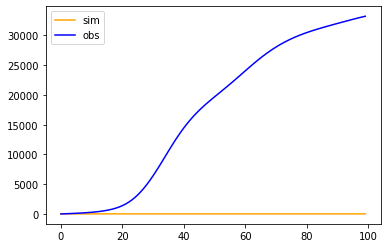

In [15]:
OpenCLRunner.update(repetitions=REPETITIONS)
OpenCLRunner.update(store_detailed_counts=STORE_DETAILED_COUNTS)

# Check the model returns the observations correctly
np.array_equal(obs0, OBSERVATIONS.loc[:len(sim0)-1,"Cases"])

# Print the fitness and plot the different disease counts
print(f"fitness: {fitness0}")
#print(pd.DataFrame({"sim":sim, "real_obs1":obs}))

fig, ax = plt.subplots(1,1)
x = range(len(sim0))
ax.plot(x, OpenCLRunner.get_cumulative_new_infections(summaries0), label="sim", color="orange")
ax.plot(x, obs0, label="obs", color="blue")
ax.legend()